In [1]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from tqdm import tqdm
from torchvision.transforms import functional as TF
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import display, Image as IPImage

from wiring_efficiency_utils import *
from neuralsheet import *
from map_plotting import *

%load_ext autoreload
%autoreload 2

/home/nicolamendini/.local/lib/python3.10/site-packages/torchvision/io/image.py:13: UserWarning: Failed to load image Python extension: libtorch_cuda_cu.so: cannot open shared object file: No such file or directory
  warn(f"Failed to load image Python extension: {e}")
/home/nicolamendini/.local/lib/python3.10/site-packages/umap/distances.py:1063: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  @numba.jit()
/home/nicolamendini/.local/lib/python3.10/site-packages/umap/distances.py:1071: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to

In [13]:
# Example usage
crop_size = 70 # Crop size (NxN)
batch_size = 64  # Number of crops to load at once
num_workers = 4  # Number of threads for data loading
root_dir = './input_stimuli'  # Path to your image folder
device = 'cuda'  # Assuming CUDA is available and desired
#M = 56  # Neural sheet dimensions
#std_exc = 0.25 # Standard deviation for excitation Gaussian
std_rfs = 5
beta = 1 - 5e-5
loss_beta = 3e-3

dataloader = create_dataloader(root_dir, crop_size, batch_size, num_workers)
#model = NeuralSheet(M, crop_size, std_exc, std_rfs, device=device).to(device)
#rf_grids = get_grids(crop_size, crop_size, model.rf_size, M, device=device)

In [14]:
# Looping over the DataLoader

trials = 20
trialvar = np.sqrt(np.linspace(1.**2, 3**2, trials))
#trialvar = [0.5, 0.625, 0.875, 1]
sizesvar = np.round(np.sqrt(np.linspace(400, 2500, 3))).astype(int)
sizesvar = [70, 30, 40, 50, 60]
sizes = len(sizesvar)
trials = len(trialvar)
noise = np.linspace(0., 0.6, trials)
print(trialvar, sizesvar, noise)
epochs = 3
reco_tracker = torch.zeros((sizes, trials, len(dataloader)))
se_tracker = torch.zeros((sizes, trials))
map_tracker = torch.zeros((sizes, trials, sizesvar[-1], sizesvar[-1]))
spectrum_tracker = torch.zeros((sizes, trials, sizesvar[-1], sizesvar[-1]))
peak_tracker = torch.zeros((sizes, trials))

tuning_curve_tracker = torch.zeros((sizes, trials, 101))
n_samples = 3
comp_tracker = torch.zeros((sizes, trials, n_samples*sizesvar[-1], n_samples*sizesvar[-1]))
se_pca_tracker = torch.zeros((sizes, trials))


for s in range(sizes):
    for t in range(trials):
        
        KEEP = False
        if not KEEP:
            model = NeuralSheet(sizesvar[s], crop_size, trialvar[t], std_rfs, device=device).to(device)
            lr = 1e-3
            rf_grids = get_grids(crop_size, crop_size, model.rf_size, sizesvar[s], device=device)

            network = init_nn(sizesvar[s], crop_size)
            avg_loss = 0

        code_tracker = []
        
        for e in range(epochs):

            batch_progress = tqdm(dataloader, leave=False)
            for b_idx, batch in enumerate(batch_progress):

                batch_responses = []
                batch_inputs = []
                batch = batch.to('cuda')  # Transfer the entire batch to GPU

                for image in batch:

                    image = image[0:1][None].flip(1)

                    if image.mean()>0.15:

                        limit = 1e-4
                        lr *= beta
                        lr = lr if lr>limit else limit
                        
                        model.hebbian_lr = lr
                        model.homeo_lr = lr

                        model(image, rf_grids, noise_lvl=0)
                        model.hebbian_step()

                        batch_responses.append(model.current_response.clone())
                        batch_inputs.append(model.current_input.clone())
                        code_tracker.append(model.current_response.clone())
                        #c = model.rf_size // 2
                        #code_tracker.append(image[:,:,c:-c,c:-c])

                batch_responses = torch.cat(batch_responses, dim=0)
                batch_inputs = torch.cat(batch_inputs, dim=0)

                reco_input = network['activ'](network['model'](batch_responses))

                targets = batch_inputs
                loss, loss_std = nn_loss(network, targets, reco_input)
                
                sim = cosim(targets.detach().cpu(), reco_input.detach().cpu(), True)
                sim = (sim - 0.6) / 0.4
                reco_tracker[s, t, b_idx] = sim
                                
                #se_mean = get_spectral_entropy(targets)       
                avg_loss = (1-loss_beta)*avg_loss + loss_beta*sim
                
                network['optim'].zero_grad()
                loss.backward()
                network['optim'].step()
                
                if b_idx%50==0:
                    ori_map, phase_map, mean_tc = get_orientations(model.afferent_weights, gabor_size=model.rf_size)

                mean_activation = model.l4_mean_activations.mean()
                mean_std = model.l4_mean_activations.std() / model.homeo_target
                batch_progress.set_description('M:{:.3f}, STD:{:.3f}, BCE:{:.3f}, LR:{:.5f}, RF:{:.4f}'.format(
                    mean_activation, 
                    mean_std, 
                    avg_loss,
                    lr,
                    mean_tc.max()
                ))
                
                #if len(code_tracker)>4000:  
                #    break

                                
        ori_map, phase_map, mean_tc = get_orientations(model.afferent_weights, gabor_size=model.rf_size)
        ori_map = ori_map.view(sizesvar[s], sizesvar[s]).cpu()
        
        eff_dims, spectrum, peak = get_effective_dims(code_tracker)
        eff_dims_pca, samp_components = get_pca_dimensions(code_tracker, n_samples)
                           
        tuning_curve_tracker[s, t] = mean_tc
        se_tracker[s, t] = eff_dims
        se_pca_tracker[s, t] = eff_dims_pca
        
        comp_size = n_samples * sizesvar[s]
        comp_tracker[s, t, :comp_size, :comp_size] = samp_components
        
        print('Reco-SE-SEPCA so far: ', avg_loss, eff_dims, eff_dims_pca)
                
        map_tracker[s, t,:sizesvar[s],:sizesvar[s]] = ori_map
        spectrum_tracker[s,t,:sizesvar[s],:sizesvar[s]] = spectrum.cpu()
        peak_tracker[s,t] = peak.cpu()
        
        
data = {
    'reco_tracker' : reco_tracker,
    'se_tracker' : se_tracker,
    'map_tracker' : map_tracker,
    'spectrum_tracker': spectrum_tracker,
    'peak_tracker': peak_tracker,
    'comp_tracker': comp_tracker,
    'se_pca_tracker': se_pca_tracker,
    'tc_tracker' : tuning_curve_tracker,
    'trialvar': trialvar,
    'sizesvar': sizesvar
}

torch.save(data, 'data.pt')

[1.         1.19207912 1.35724179 1.50437957 1.63835604 1.76217569
 1.87784871 1.98679854 2.09007681 2.18848662 2.28265773 2.3730948
 2.46020966 2.54434357 2.62578309 2.70477161 2.78151795 2.85620285
 2.92898402 3.        ] [70, 30, 40, 50, 60] [0.         0.03157895 0.06315789 0.09473684 0.12631579 0.15789474
 0.18947368 0.22105263 0.25263158 0.28421053 0.31578947 0.34736842
 0.37894737 0.41052632 0.44210526 0.47368421 0.50526316 0.53684211
 0.56842105 0.6       ]


KeyboardInterrupt: 

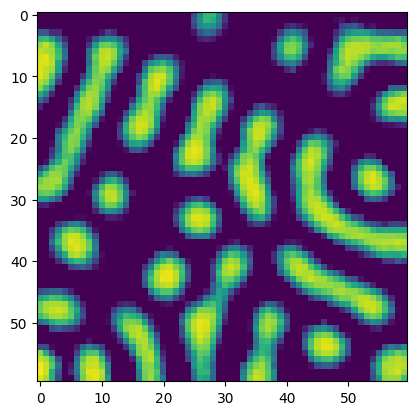

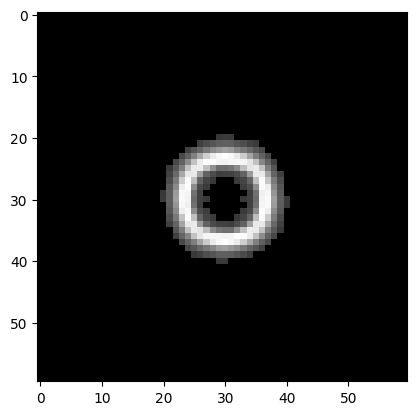

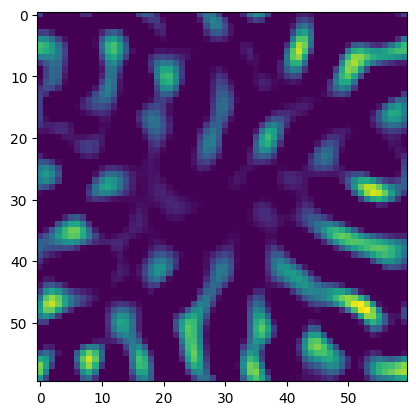

tensor(0.6711) tensor(291)


In [11]:
eff_dims, spectrum, peak = get_effective_dims(code_tracker, debug=True)

In [140]:
model.aff_strength

tensor(0.2132, device='cuda:0')

In [57]:
make_compx_plots(torch.load('data_12Jun.pt'))

In [117]:
data = torch.load('data_12Jun.pt')
se_tracker = data['se_tracker']
reco_tracker = data['reco_tracker']

Net Afferent Max: 0.172, Net Afferent Min: -0.273
L4 Thresholds Max: 0.316, L4 Thresholds Min: 0.246
Mean current response: 0.019
L4 Strength: 3.801 aff strength: 0.739
Reco loss: 0.062%


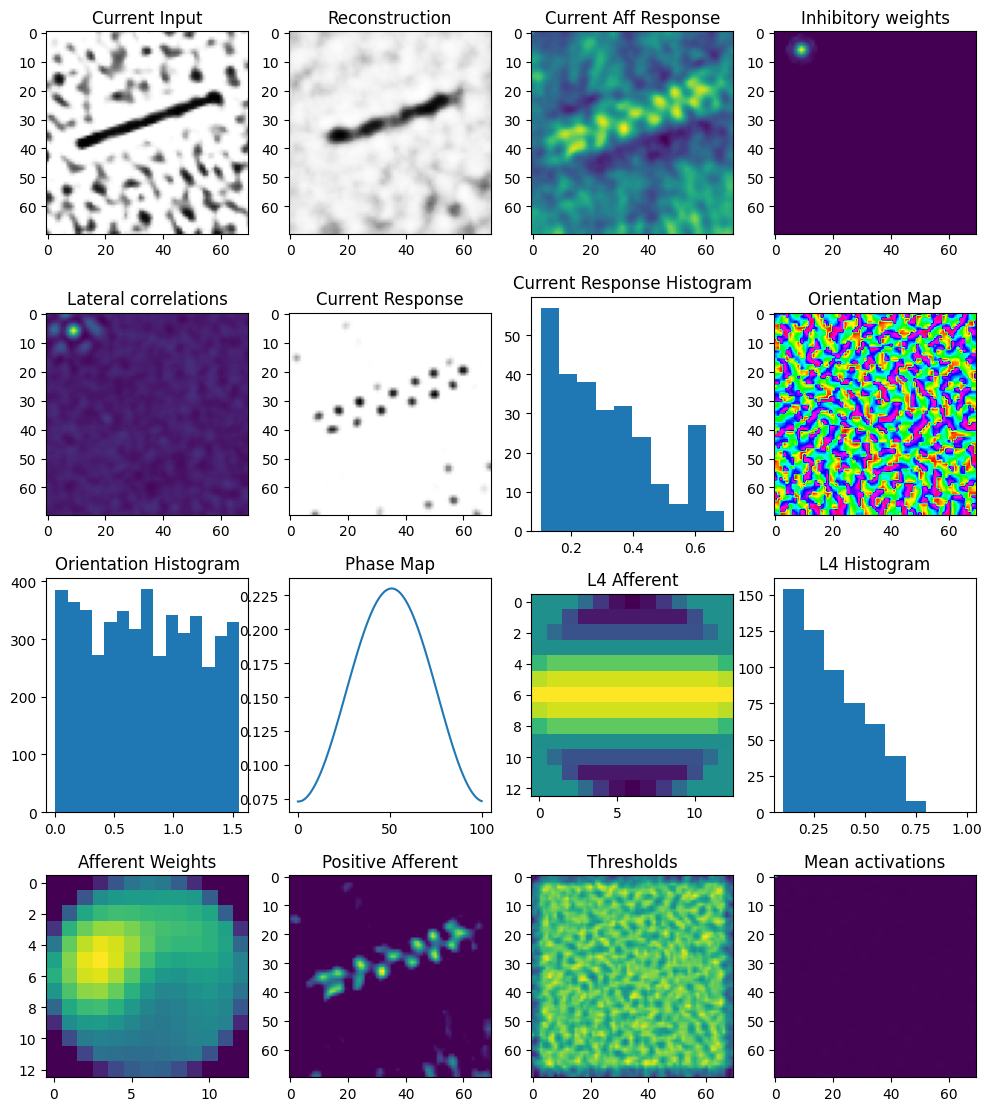

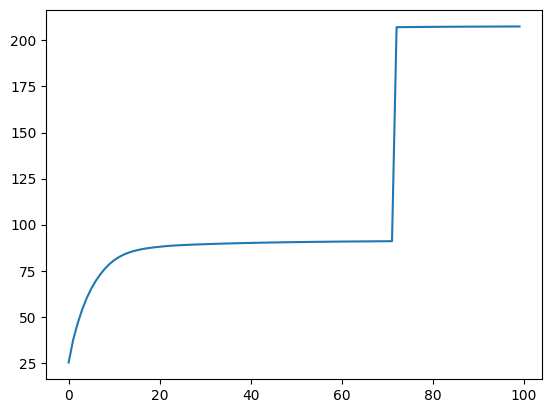

In [35]:
%matplotlib inline

random_sample = random.randint(0, model.afferent_weights.shape[0] - 1)
#random_batch = random.randint(0, batch.shape[0] - 1)

model(batch[random_batch, 0:1][None].flip(1),rf_grids,noise_lvl=noise[0])
show_map(model, network, random_sample)
model.current_response.max()
array = model.response_tracker.cpu()[:,0]
array[:,0,0] = 1
anim = animate(array, model.iterations)
plt.plot(model.response_tracker[:model.iterations].sum([1,2,3]).cpu())
anim

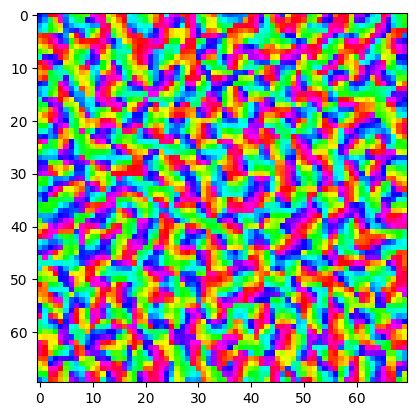

In [16]:
ori, _, _ = get_orientations(model.get_aff_weights(), gabor_size=13)
plt.imshow(ori.cpu().view(model.sheet_size,model.sheet_size), cmap='hsv')

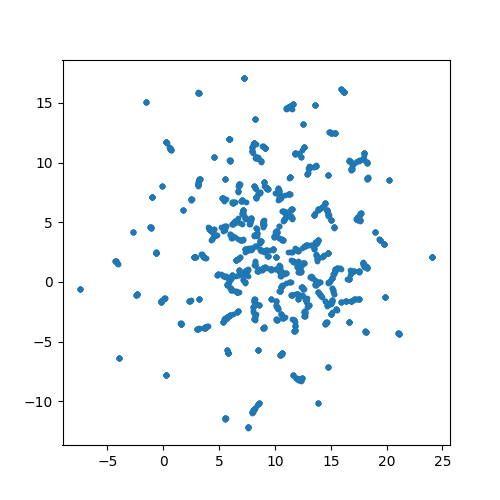

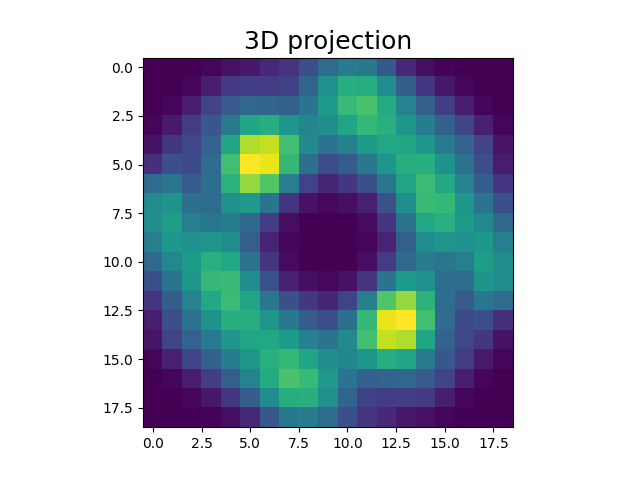

In [575]:
%matplotlib widget
code_tracker = []
for i in range(500):
    
    ori = random.random()*180
    phase = random.random()*90
    
    gratings = get_gratings(crop_size, ori, 12, phase)[None,None].cuda()**2 * 0.6
    
    model(gratings, rf_grids, noise_lvl=0, adaptation=False)
    
    code_tracker.append(model.current_response.clone().cpu())
    
    
#embedding, codes_var = get_umap(code_tracker, 15)
embedding, autocorrelograms = select_grid_modules(code_tracker, 19)
draw_umap(embedding, 5, dims=2)
plt.imshow(autocorrelograms[random.randint(0,autocorrelograms.shape[0]-1)].cpu().view(19,19))
plt.show()

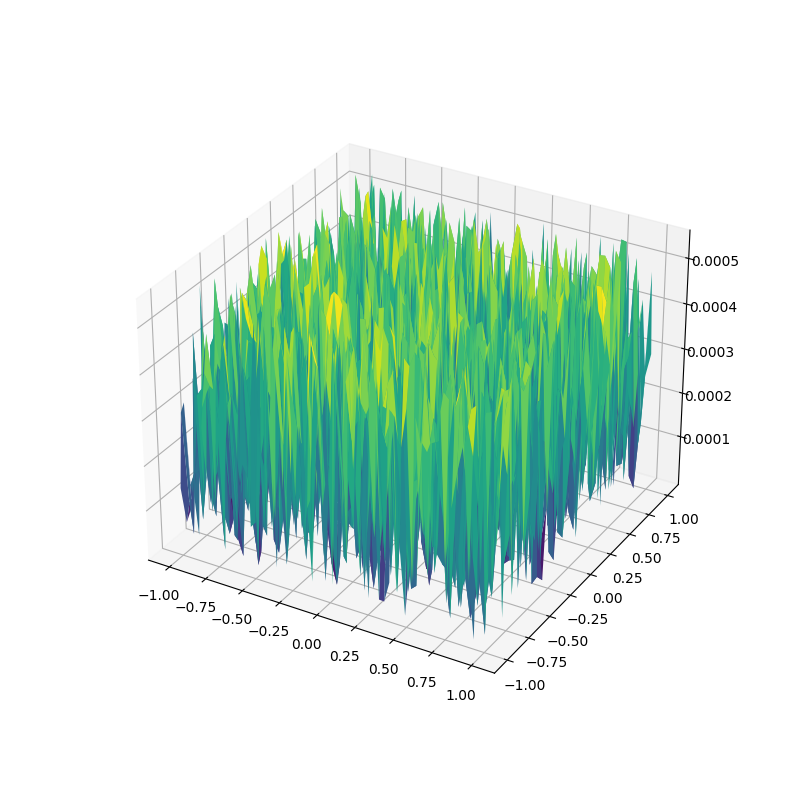

In [237]:
%matplotlib widget
sample = np.random.randint(0, model.sheet_size**2)
x = np.linspace(-1, 1, M)
y = np.linspace(-1, 1, M)
x, y = np.meshgrid(x, y)
z = model.lateral_correlations[sample,0].cpu() #* model.masks[sample,0].cpu()
#z = z*model.eq + model.untuned_inh[sample,0].cpu()*(1-model.eq)
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111, projection='3d')


ax.plot_surface(x, y, z, cmap='viridis', edgecolor='none', rstride=1, cstride=1, alpha=1)
plt.show()

<Figure size 640x480 with 0 Axes>

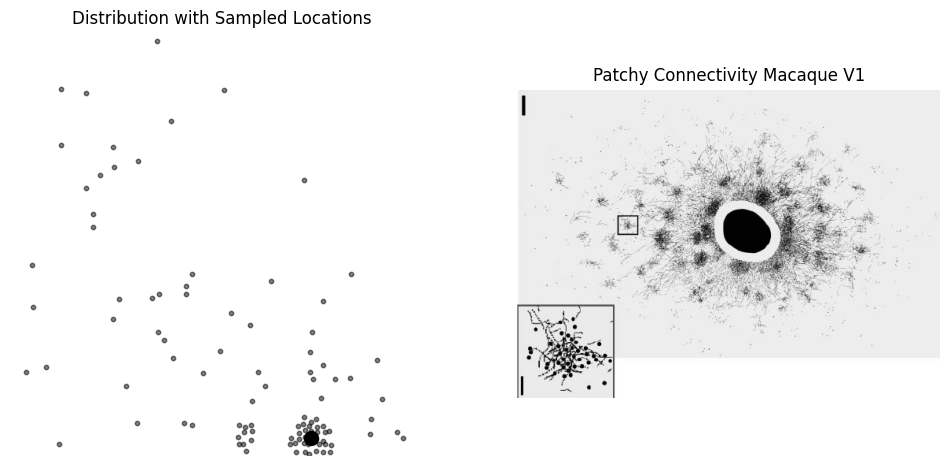

In [582]:
plt.clf()
%matplotlib inline

num_samples = 100   # Number of samples you want to draw
theta = 0

# Assuming model.sheet_size and M are defined elsewhere
# model.sheet_size = ...  
M = model.sheet_size

sample_idx = np.random.randint(0, model.sheet_size**2)
z = model.lateral_correlations[sample_idx, 0].cpu()

# Generate an example distribution (MxM)
# This could be your actual distribution, ensure it sums to 1 if it represents probabilities
distribution = torch.relu(z - theta)
distribution /= distribution.sum()

sample_and_plot(distribution, num_samples, sample_idx)

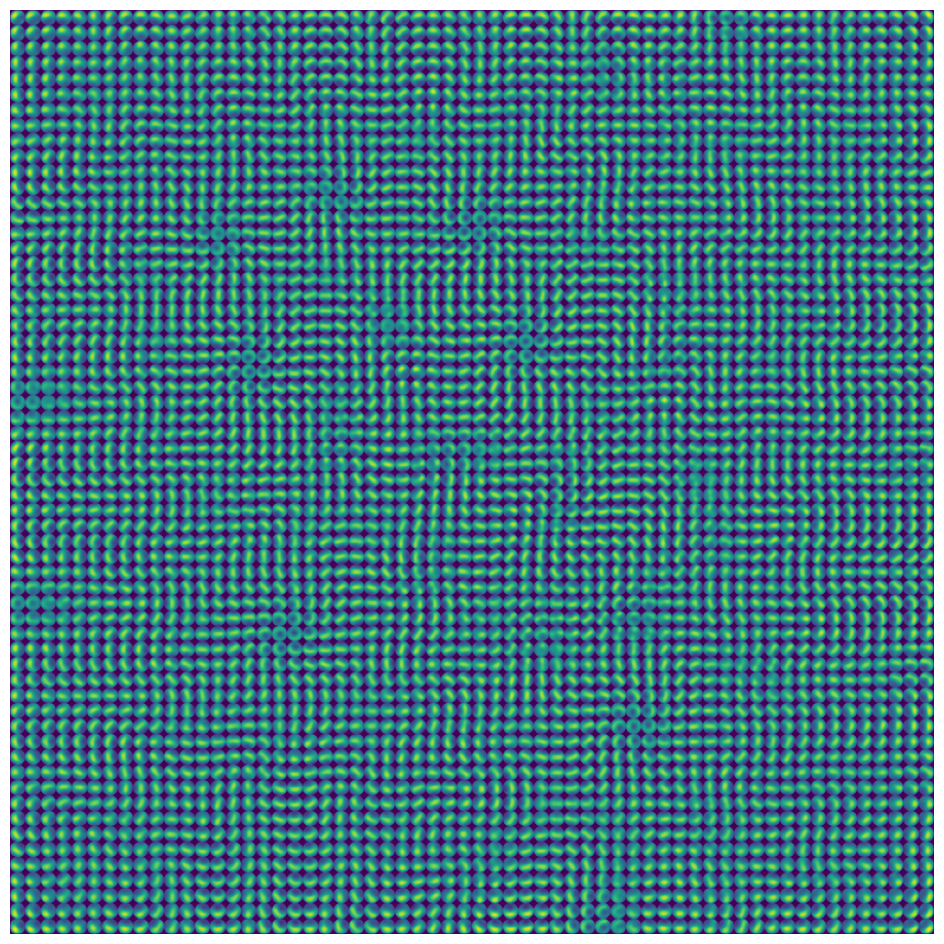

In [116]:
%matplotlib inline
angles = model.get_aff_weights().cpu()
angles = angles.view(model.sheet_size, model.sheet_size, model.rf_size, model.rf_size)
angles = angles.permute(0,2,1,3).reshape(model.sheet_size*model.rf_size, model.sheet_size*model.rf_size)
plt.figure(figsize=(12,12))
plt.axis('off')
plt.imshow(angles)

In [101]:
state = {

    'afferent' : model.afferent_weights,
    'lateral' : model.lateral_correlations
    
}

In [102]:
torch.save(state, 'state.pt')

In [4]:
state = torch.load('state.pt')
model.afferent_weights = state['afferent']
model.lateral_correlations = state['lateral']